<a href="https://colab.research.google.com/github/JuanBustamante107517/Lab_08_Bustamante_G/blob/main/Lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

from scipy import stats


### a.	Realice el preprocesamiento de la información que incluya el análisis de datos faltantes, tratamiento de outliers a nivel univariado y multivariado, escalamiento de datos para las variables numéricas y dumización para las variables categóricas. Además, elimine las variables ‘fabricante’, ‘modelo’, ‘transmision’, ‘traccion’, ‘clase’, ‘combustible’ y ‘consumo’.

In [2]:
df = pd.read_csv('/content/vehículos.csv')
df.head()


,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


In [7]:
#Tratamiento de datos faltantes

# Separar variables numéricas y categóricas
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

# Imputar numéricas con media
imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Imputar categóricas con moda
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])


In [8]:
#Tratamiento de outliers univariado usando IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers_iqr(df, num_cols)


In [9]:
#Tratamiento de outliers multivariado con Z-score
z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]


In [10]:
#Escalamiento de datos numéricos
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)


In [11]:
#Dumificación de variables categóricas
df_dummies = pd.get_dummies(df[cat_cols], drop_first=True)


In [12]:
#Eliminación de columnas indicadas
cols_to_drop = ['fabricante', 'modelo', 'transmision', 'traccion', 'clase', 'combustible', 'consumo']
df = df.drop(columns=cols_to_drop, errors='ignore')


### b.	Aplique un análisis de conglomerados no jerárquico por medio del método k-means y utilice el método del codo para determinar la cantidad de clusters adecuados. Compare los conglomerados formados y comente sobre las características que definen a estos.

In [13]:
#Unir variables numéricas escaladas y categóricas dummificadas
X = pd.concat([df_scaled.reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)


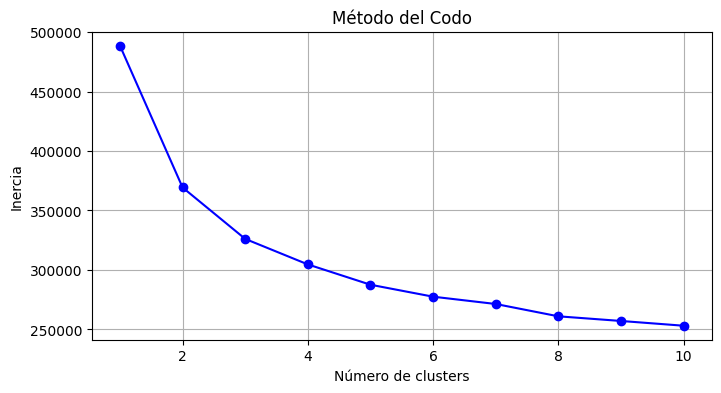

In [14]:
#Método del codo para determinar número óptimo de clusters
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()


In [15]:
#Aplicación de K-means con número óptimo de clusters (ajusta según el gráfico)
k_opt = 3  # reemplaza este valor si el codo sugiere otro
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


In [16]:
#Visualización de distribución de clusters
df['cluster'].value_counts().sort_index()


,count
cluster,
0,9007
1,11481
2,13629


### c.	Calcule las principales medidas de evaluación interna e interprete los resultados obtenidos. También, calcule las principales medidas de evaluación externa tomando una cantidad de clusters de 8 y de referencia a la variable ‘clase_tipo’.

In [17]:
#Evaluación interna: Silhouette Score
sil_score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.155


In [18]:
#Evaluación externa con 8 clusters y comparación con 'clase_tipo'
kmeans_8 = KMeans(n_clusters=8, random_state=42)
df['cluster_8'] = kmeans_8.fit_predict(X)

# Verifica que exista la columna 'clase_tipo'
if 'clase_tipo' in df.columns:
    ari = adjusted_rand_score(df['clase_tipo'], df['cluster_8'])
    nmi = normalized_mutual_info_score(df['clase_tipo'], df['cluster_8'])

    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
else:
    print("La columna 'clase_tipo' no está en el DataFrame. Verifica su nombre.")


Adjusted Rand Index (ARI): 0.106
Normalized Mutual Information (NMI): 0.165
